In [1]:
'''
re                - to remove english letters in dataset
string            - to remove punctuations
numpy             - basic array operations
pandas            - to manage DataFrames
itertools groupby - to remove consecutive duplicates
'''
import re
import string
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import groupby
from progressbar import ProgressBar
from nltk.translate.bleu_score import corpus_bleu

#to join paths, list directories in the dataset
import os
from os import listdir

#to load images
from PIL import Image

#to save and load pickle files
from pickle import load
from pickle import dump

#to plot loaded images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

'''
tensorflow                           - for all model trainings, preprocessings, etc
Input                                - for input layer
to_categorical                       - to encode text sequences
Model, load_model                    - to work with any model or load a saved model
pad_sequences                        - to pad text sequences with zeros
load_img, img_to_array               - as the name suggests
Dropout, Embedding, LSTM, Dense, Add - various layers
preprocess_input, InceptionV3        - The InceptionV3 model itself and a preprocessing library for the model
'''
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dropout, Embedding, LSTM, Dense, Add
from tensorflow.keras.applications.inception_v3 import preprocess_input, InceptionV3

#to handle an error while training the final model
tf.config.run_functions_eagerly(True)

In [2]:
import glob
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Colab Notebooks"

Mounted at /content/drive
 aanish.ipynb.txt
'Automatic Image Captioning.ipynb'
'Copy of 1.Python_Basics.ipynb'
'Copy of 2.Neural_Network.ipynb'
'Copy of 3.Convolutional_Neural_Networks.ipynb'
'Copy of task_1_classification_metrics.ipynb'
'Copy of task1_LinearRegression.ipynb'
'Copy of task_1_logistic_divorse.ipynb'
'Copy of task_1_multiclass_logistic_obesity.ipynb'
'Copy of task_1_simple.ipynb'
'Copy of task_1_tabular.ipynb'
'Copy of task_2_decision_tree_viz.ipynb'
'Copy of task_2_dt_log.ipynb'
'Copy of task_2_image.ipynb'
'Copy of task_2_logistic_diabetes.ipynb'
'Copy of task_2_lr_vs_dt.ipynb'
'Copy of task_2_multiple.ipynb'
 DL_lab10.ipynb
'dl lab2 part2.ipynb.txt'
 DL_LAB5.ipynb
 E18CSE003_LAB7_DL.ipynb
 E18CSE044_DL_LAB6.ipynb
 E18CSE044_Mini_Hackathon.ipynb
 E18CSE044_Task_1_feature_elimination.ipynb
 final.ipynb
 fliker8ktelugu
'Image Caption Generator - Telugu Evaluation.ipynb'
'satya lab8.ipynb'
 Task_1_RandomForest_from_scratch.ipynb
 task_1_simple.txt
 Task_2_Adaboost_Classif

In [3]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d shadabhussain/flickr8k

100% 2.12G/2.13G [00:28<00:00, 102MB/s] 
100% 2.13G/2.13G [00:28<00:00, 79.8MB/s]


In [5]:
!unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: flickr_data/Flickr_Data/Images/2845691057_d4ab89d889.jpg  
  inflating: flickr_data/Flickr_Data/Images/2845845721_d0bc113ff7.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846037553_1a1de50709.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846785268_904c5fcf9f.jpg  
  inflating: flickr_data/Flickr_Data/Images/2846843520_b0e6211478.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847514745_9a35493023.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847615962_c330bded6e.jpg  
  inflating: flickr_data/Flickr_Data/Images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848266893_9693c66275.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848571082_26454cb981.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848895544_6d06210e9d.jpg  
  inflating: flickr_data/Flickr_Data/Images/2848977044_446a31d86e.jpg  
  inflating: flickr_data/Flickr_Data/Images/2849194983_2968c72832.jpg  
  inflating: 

In [6]:
captions_dir = '/content/drive/MyDrive/Flickr8kTelugu.token.txt'
train_images_dir = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
test_images_dir = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
descriptions_dir = '/content/drive/MyDrive/final project files/descriptions.txt'
images_dir = '/content/Flickr_Data/Flickr_Data/Images/'
# embeddings_dir = 'Word Embeddings/cc.te.300.vec.txt'
# embedding_dim = 300
train_images_pkl_dir = '/content/drive/MyDrive/second_encoded_train_images.pkl'
# models_dir = 'Models/'
test_img_dir = '/content/Flickr_Data/Flickr_Data/Images/1075867198_27ca2e7efe.jpg'
test_model_dir = '/content/drive/MyDrive/models/model_199.h5'
embeddings_matrix_dir = '/content/drive/MyDrive/final project files/embeddings_matrix.npy'
start_token = 'Start '
end_token = ' End'

In [7]:
#function to load an read a text file
def load_doc(filename):
    
    #opening the file as read only
    file = open(filename, 'r')
    
    #reading all text
    text = file.read()
    
    #closeing the file
    file.close()
    
    return text

In [8]:
#All the image names and captions are stored in descriptions
descriptions = dict()

#reading the file
doc = load_doc(captions_dir)

#iterating through the lines
for line in doc.split('\n'):
    
    #seperating id and captions
    tokens = line.split('\t')
    image_id, image_desc = tokens[0], tokens[1:]
    
    image_id = image_id.split('.')[0]
    image_desc = ' '.join(image_desc)
    
    #adding to the descriptions dictionaty
    if image_id not in descriptions:
        descriptions[image_id] = list()
    
    descriptions[image_id].append(image_desc)

In [9]:
#checking
descriptions['1000268201_693b08cb0e']

['గులాబీ రంగు దుస్తులు ధరించిన పిల్లవాడు ప్రవేశ మార్గంలో ఒక మెట్ల పైకి ఎక్కుతున్నాడు.',
 'ఒక చెక్క భవనంలోకి వెళుతున్న అమ్మాయి.',
 'ఒక చిన్న అమ్మాయి చెక్క ప్లేహౌస్ పైకి ఎక్కడం.',
 'ఒక చిన్న అమ్మాయి తన ప్లేహౌస్కు మెట్లు ఎక్కేది.',
 'గులాబీ రంగు దుస్తులు ధరించిన ఒక చిన్న అమ్మాయి చెక్క క్యాబిన్లోకి వెళుతుంది.']

In [10]:
#checking total images
len(descriptions)

8093

In [11]:
#function to save the descriptions to a text file
def save_descriptions(descriptions, filename):
    
    lines = list()
    
    #iterating through the items
    for key, desc_list in descriptions.items():
        
        #iterating through the captions
        for desc in desc_list:
            
            #appending
            lines.append(key + ' ' + desc)
    
    #joining
    data = '\n'.join(lines)
    
    #file handling
    file = open(filename, 'w')
    file.write(data)
    file.close()

#saving descriptions
save_descriptions(descriptions, descriptions_dir)

In [12]:
#cleaning the captions
table = str.maketrans('', '', string.punctuation)

#iterating through all items
for key, desc_list in descriptions.items():
    
    #iterating through captions of each image
    for i in range(len(desc_list)):
        
        #getting ith caption
        desc = desc_list[i]
        
        #tokenizing
        desc = desc.split()
        
        #removing punctuation from each token
        desc = [w.translate(table) for w in desc]
        
        #removing \u200c
        #\u200c is a seperator generated during translation
        desc = [' '.join(word.split('\u200c')) for word in desc]
        
        #removing english letters generated during translation
        desc = [word for word in desc if not re.match(r'[A-Z]+', word, re.I)]
        
        #putting back the caption
        desc_list[i] =  ' '.join(desc)

In [13]:
#generating all train images list
train = list()

#reading the file
doc = load_doc(train_images_dir)

#iterating through the lines
for line in doc.split('\n'):
    
    #skipping empty lines
    if len(line) < 1:
        continue
    
    #appending the image id
    identifier = line.split('.')[0]
    train.append(identifier)

print('Dataset: %d' % len(train))

Dataset: 6000


In [14]:
#generating train descriptions
train_descriptions = dict()

#loading descriptions
doc = load_doc(descriptions_dir)

#making set of train images
dataset = set(train)

#iterating through descriptions
for line in doc.split('\n'):
    
    #splitting line by white space
    tokens = line.split()
    
    #try splitting id from captions else skip
    try:
        image_id, image_desc = tokens[0], tokens[1:]
    except:
        continue
    
    #skipping images if not in the train set
    if image_id in dataset:
        
        #initiating an entry if image is for the first time
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        
        #wrapping description in tokens
        desc = start_token + ' '.join(image_desc) + end_token
        
        #storing
        train_descriptions[image_id].append(desc)

        print('Descriptions: train=%d' % len(train_descriptions))

Streaming output truncated to the last 5000 lines.
Descriptions: train=5001
Descriptions: train=5001
Descriptions: train=5001
Descriptions: train=5001
Descriptions: train=5001
Descriptions: train=5002
Descriptions: train=5002
Descriptions: train=5002
Descriptions: train=5002
Descriptions: train=5002
Descriptions: train=5003
Descriptions: train=5003
Descriptions: train=5003
Descriptions: train=5003
Descriptions: train=5003
Descriptions: train=5004
Descriptions: train=5004
Descriptions: train=5004
Descriptions: train=5004
Descriptions: train=5004
Descriptions: train=5005
Descriptions: train=5005
Descriptions: train=5005
Descriptions: train=5005
Descriptions: train=5005
Descriptions: train=5006
Descriptions: train=5006
Descriptions: train=5006
Descriptions: train=5006
Descriptions: train=5006
Descriptions: train=5007
Descriptions: train=5007
Descriptions: train=5007
Descriptions: train=5007
Descriptions: train=5007
Descriptions: train=5008
Descriptions: train=5008
Descriptions: train=5008

In [15]:
#consider only words which occur at least 10 times in the corpus
#creating a list of all the training captions
all_train_captions = []

#iterating through items
for key, val in train_descriptions.items():
    
    #iterating through each caption
    for cap in val:
        
        #appending
        all_train_captions.append(cap)

#generating word frequency dictionary
word_counts = {}
word_count_threshold = 10
nsents = 0

#iterating through all train captions
for sent in all_train_captions:
    
    #incrementing sentences count
    nsents += 1
    
    #iterating through words of sentence
    for w in sent.split(' '):
        
        #incrementing particular word count
        word_counts[w] = word_counts.get(w, 0) + 1

#listing words of frequency more than 10
vocabulary = [w for w in word_counts if word_counts[w] >= word_count_threshold]

#words with frequency more than 10
print('Preprocessed words: ', len(vocabulary))

Preprocessed words:  2308


In [16]:
#generating index-to-word and word-to-index dictionaries
ixtoword = {}
wordtoix = {}
ix = 0

#iterating through unique words vocabulary
for w in vocabulary:
    
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

#converting a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    
    all_desc = list()
    
    #iterating through the keys
    for key in descriptions.keys():
        
        #appending with each caption
        [all_desc.append(d) for d in descriptions[key]]
    
    return all_desc

#calculating the length of the description with the most words
def max_length(descriptions):
    
    #getting all descriptions
    lines = to_lines(descriptions)
    
    #returning max length
    return max(len(d.split()) for d in lines)

#getting the maximum sequence length
max_length = max_length(train_descriptions)
print('Max Description Length: %d' % max_length)

Max Description Length: 30


In [17]:
#generating embedding matrix for vocabulary
embedding_matrix = np.load(embeddings_matrix_dir)

In [18]:
#function for yielding training batches
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    
    X1, X2, y = list(), list(), list()
    n = 0
    
    #looping for ever over images
    while 1:
        
        #iterating over items
        for key, desc_list in descriptions.items():
            
            #trying to retrieve the photo feature else skip
            try:
                photo = photos[key]
                photo = np.reshape(photo, photo.shape[1])   
            except KeyError:
                continue
                
            #incrementing images count
            n += 1
            
            #iterating through all descriptions
            for desc in desc_list:
                
                #encoding the sequence with numbers
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                
                #splitting one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    
                    #splitting into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    
                    #padding input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    
                    #encoding output sequence
                    out_seq = to_categorical([out_seq], num_classes=len(vocabulary))[0]
                    
                    #storing
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            
            #yielding the batch data if photos equals batch size
            if n == num_photos_per_batch:
                
                yield ([np.array(X1), np.array(X2)], np.array(y))
                
                #resetting lists and image count
                X1, X2, y = list(), list(), list()
                n = 0

In [19]:
#function for predicting captions by greedy search algorithm
def greedySearch(photo, model):
    
    #defining starting word
    in_text = start_token[:-1]
    
    #iterating over the length of largest caption
    for i in range(15):
        
        #converting words to indexes
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        
        #padding with zeros to match max length
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        #predicting the next word's index
        yhat = model.predict([photo,sequence])
        yhat = np.argmax(yhat)
        
        #convering index to word and appending to sentence
        word = ixtoword[yhat]
        in_text += ' ' + word
        
        #early stopping in case end sequence is predicted
        if word == end_token[1:]:
            break
    
    #stripping initial and final tokens from sentence and removing duplicate predictions
    final = in_text.split()
    final = final[1:-1]
    final = [x[0] for x in groupby(final)]
    final = ' '.join(final)
    
    return final

In [20]:
#function to pre-process image for prediction
def test_img(filename):
    
    #load the InceptionV3 model with imagenet weights
    model = InceptionV3(weights='imagenet')
    
    #re-structuring the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    #loading the image from file
    image = load_img(filename, target_size=(299, 299))
    
    #converting the image pixels to a numpy array
    image = img_to_array(image)
    
    #reshaping data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    #preprocessing the image for the InceptionV3 model
    image = preprocess_input(image)
    
    #getting features
    feature = model.predict(image, verbose=0)
    
    #returning the reshaped features
    return np.reshape(feature, (1, feature.shape[1]))

96116736/96112376 [==============================] - 1s 0us/step


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


కుక్కలతో బీచ్ లో ముగ్గురు కుక్కలతో ఆడుతున్నారు చూస్తున్నారు బంతిని చూస్తున్నారు మరొకటి కుక్క గాలిలో దూకుతోంది


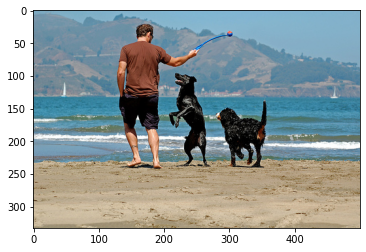

In [21]:
#uncomment to load a model with custom weights
model = load_model(test_model_dir)

#pre-processing test image
test = test_img(test_img_dir)

#loading and plotting test image
img = mpimg.imread(test_img_dir)
plt.imshow(img)

#printing the generated caption
print(greedySearch(test, model))

In [22]:
#generating all test images list
test = list()

#reading the file
doc = load_doc(test_images_dir)

#iterating through the lines
for line in doc.split('\n'):
    
    #skipping empty lines
    if len(line) < 1:
        continue
    
    #appending the image id
    identifier = line.split('.')[0]
    test.append(identifier)

print('Dataset: %d' % len(test))

Dataset: 1000


In [23]:
#generating train descriptions
test_descriptions = dict()

#loading descriptions
doc = load_doc(descriptions_dir)

#making set of train images
dataset = set(test)

#iterating through descriptions
for line in doc.split('\n'):
    
    #splitting line by white space
    tokens = line.split()
    
    #try splitting id from captions else skip
    try:
        image_id, image_desc = tokens[0], tokens[1:]
    except:
        continue
    
    #skipping images if not in the train set
    if image_id in dataset:
        
        #initiating an entry if image is for the first time
        if image_id not in test_descriptions:
            test_descriptions[image_id] = list()
        
        #wrapping description in tokens
        desc = ' '.join(image_desc)
        
        #storing
        test_descriptions[image_id].append(desc)

        print('Descriptions: train=%d' % len(test_descriptions))

Streaming output truncated to the last 5000 lines.
Descriptions: train=1
Descriptions: train=1
Descriptions: train=1
Descriptions: train=1
Descriptions: train=1
Descriptions: train=2
Descriptions: train=2
Descriptions: train=2
Descriptions: train=2
Descriptions: train=2
Descriptions: train=3
Descriptions: train=3
Descriptions: train=3
Descriptions: train=3
Descriptions: train=3
Descriptions: train=4
Descriptions: train=4
Descriptions: train=4
Descriptions: train=4
Descriptions: train=4
Descriptions: train=5
Descriptions: train=5
Descriptions: train=5
Descriptions: train=5
Descriptions: train=5
Descriptions: train=6
Descriptions: train=6
Descriptions: train=6
Descriptions: train=6
Descriptions: train=6
Descriptions: train=7
Descriptions: train=7
Descriptions: train=7
Descriptions: train=7
Descriptions: train=7
Descriptions: train=8
Descriptions: train=8
Descriptions: train=8
Descriptions: train=8
Descriptions: train=8
Descriptions: train=9
Descriptions: train=9
Descriptions: train=9
Des

In [24]:
#generating train descriptions
train_descriptions = dict()

#loading descriptions
doc = load_doc(descriptions_dir)

#making set of train images
dataset = set(train)

#iterating through descriptions
for line in doc.split('\n'):
    
    #splitting line by white space
    tokens = line.split()
    
    #try splitting id from captions else skip
    try:
        image_id, image_desc = tokens[0], tokens[1:]
    except:
        continue
    
    #skipping images if not in the train set
    if image_id in dataset:
        
        #initiating an entry if image is for the first time
        if image_id not in train_descriptions:
            train_descriptions[image_id] = list()
        
        #wrapping description in tokens
        desc = ' '.join(image_desc)
        
        #storing
        train_descriptions[image_id].append(desc)

        print('Descriptions: train=%d' % len(train_descriptions))

Streaming output truncated to the last 5000 lines.
Descriptions: train=5001
Descriptions: train=5001
Descriptions: train=5001
Descriptions: train=5001
Descriptions: train=5001
Descriptions: train=5002
Descriptions: train=5002
Descriptions: train=5002
Descriptions: train=5002
Descriptions: train=5002
Descriptions: train=5003
Descriptions: train=5003
Descriptions: train=5003
Descriptions: train=5003
Descriptions: train=5003
Descriptions: train=5004
Descriptions: train=5004
Descriptions: train=5004
Descriptions: train=5004
Descriptions: train=5004
Descriptions: train=5005
Descriptions: train=5005
Descriptions: train=5005
Descriptions: train=5005
Descriptions: train=5005
Descriptions: train=5006
Descriptions: train=5006
Descriptions: train=5006
Descriptions: train=5006
Descriptions: train=5006
Descriptions: train=5007
Descriptions: train=5007
Descriptions: train=5007
Descriptions: train=5007
Descriptions: train=5007
Descriptions: train=5008
Descriptions: train=5008
Descriptions: train=5008

In [25]:
# evaluate the skill of the model
def evaluate_model_limited_data(model, descriptions, number_of_images):
    actual, predicted = list(), list()
    n=1
    # step over the whole set
    for key, desc_list in test_descriptions.items():
        if n > number_of_images:
            break
        # generate description
        img = test_img(images_dir + key + '.jpg')
        yhat = greedySearch(img, model)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
        print(n)
        n+=1
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [26]:
# evaluate the skill of the model
def evaluate_model_all_data(model, descriptions, test, train, test_descriptions, train_descriptions):
    actual, predicted = list(), list()
    train_actual, train_predicted = list(), list()
    test_actual, test_predicted = list(), list()
    n=1
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        img = test_img(images_dir + key + '.jpg')
        yhat = greedySearch(img, model)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        if key in train:
            train_actual.append(references)
            train_predicted.append(yhat.split())
        if key in test:
            test_actual.append(references)
            test_predicted.append(yhat.split())
        actual.append(references)
        predicted.append(yhat.split())
        print(n)
        n+=1
    bleu, train_bleu, test_bleu = [], [], []
  
    bleu.append(corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    bleu.append(corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    bleu.append(corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    bleu.append(corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

    train_bleu.append(corpus_bleu(train_actual, train_predicted, weights=(1.0, 0, 0, 0)))
    train_bleu.append(corpus_bleu(train_actual, train_predicted, weights=(0.5, 0.5, 0, 0)))
    train_bleu.append(corpus_bleu(train_actual, train_predicted, weights=(0.3, 0.3, 0.3, 0)))
    train_bleu.append(corpus_bleu(train_actual, train_predicted, weights=(0.25, 0.25, 0.25, 0.25)))

    test_bleu.append(corpus_bleu(test_actual, test_predicted, weights=(1.0, 0, 0, 0)))
    test_bleu.append(corpus_bleu(test_actual, test_predicted, weights=(0.5, 0.5, 0, 0)))
    test_bleu.append(corpus_bleu(test_actual, test_predicted, weights=(0.3, 0.3, 0.3, 0)))
    test_bleu.append(corpus_bleu(test_actual, test_predicted, weights=(0.25, 0.25, 0.25, 0.25)))

    np.save('bleu.npy', np.array(bleu))
    np.save('train_bleu.npy', np.array(train_bleu))
    np.save('test_bleu.npy', np.array(test_bleu))
    # calculate BLEU score
    print('BLEU-1: %f' % bleu[0])
    print('BLEU-2: %f' % bleu[1])
    print('BLEU-3: %f' % bleu[2])
    print('BLEU-4: %f' % bleu[3])
    

In [ ]:
def predict_for_all(model, descriptions, skip_lines):
    predicted = []
    n=1
    skip_count = 0
    # step over the whole set
    for key, desc_list in descriptions.items():
        if skip_count < skip_lines:
            skip_count += 1
            continue
        # generate description
        img = test_img(images_dir + key + '.jpg')
        yhat = greedySearch(img, model)
        with open('predictions.txt', 'a') as file:
            file.write(yhat + '\n')
        print(n)
        n+=1

In [ ]:
def evaluate_random(model, descriptions, images_list):
    random_images = random.sample(images_list, 50)
    actual, predicted = [], []
    for i in range(50):
        img = test_img(images_dir + random_image[i] + '.jpg')
        yhat = greedySearch(img, model)
        desc_list = descriptions[random_image[i]]
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
        print(i+1)
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [ ]:
# evaluate_model_all_data(model, descriptions, test, train, test_descriptions, train_descriptions)
evaluate_random(model, descriptions, train)
# evaluate_random(model, descriptions, test)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3350: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  "Even though the tf.config.experimental_run_functions_eagerly "


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
